In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import sys
sys.path.append('../code')
import dataframe_utilities as util

In [4]:
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials
from functools import partial

# Get Data

In [5]:
df = pd.read_csv('../data/df_w_features.csv', low_memory=False)
df.shape

(24079, 590)

In [6]:
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

In [7]:
X_train = X[:-300]
y_train = y[:-300]
X_valid = X[-300:]
y_valid = y[-300:]

In [8]:
cats = [x for x in X.columns if X[x].dtype=='object']
encoder = ce.CatBoostEncoder(cols=cats, random_state=13)
# encoder = ce.TargetEncoder(cols=cats)
X_train = encoder.fit_transform(X_train, y_train)
X_valid = encoder.transform(X_valid)
cats

['home_team_abbr',
 'away_team_abbr',
 'home_pitcher',
 'away_pitcher',
 'home_team_season',
 'away_team_season']

# Quick Look

In [9]:
xgb_params = {'colsample_bytree': 0.75,
 'learning_rate': 0.01,
 'max_depth': 28,
 'min_child_weight': 14.0,
 'reg_alpha': 0.42431,
 'subsample': 0.2}

In [10]:
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.438748	validation_1-error:0.47
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.419067	validation_1-error:0.436667
[2]	validation_0-error:0.407376	validation_1-error:0.436667
[3]	validation_0-error:0.400479	validation_1-error:0.413333
[4]	validation_0-error:0.393919	validation_1-error:0.43
[5]	validation_0-error:0.387821	validation_1-error:0.426667
[6]	validation_0-error:0.384541	validation_1-error:0.443333
[7]	validation_0-error:0.383448	validation_1-error:0.403333
[8]	validation_0-error:0.381807	validation_1-error:0.4
[9]	validation_0-error:0.378023	validation_1-error:0.406667
[10]	validation_0-error:0.376803	validation_1-error:0.41
[11]	validation_0-error:0.373439	validation_1-error:0.413333
[12]	validation_0-error:0.372219	validation_1-error:0.42
[13]	validation_0-error:0.372303	validation_1-error:0.416667
[14]	validation_

(0.6366666666666667, 0.622565044109086)

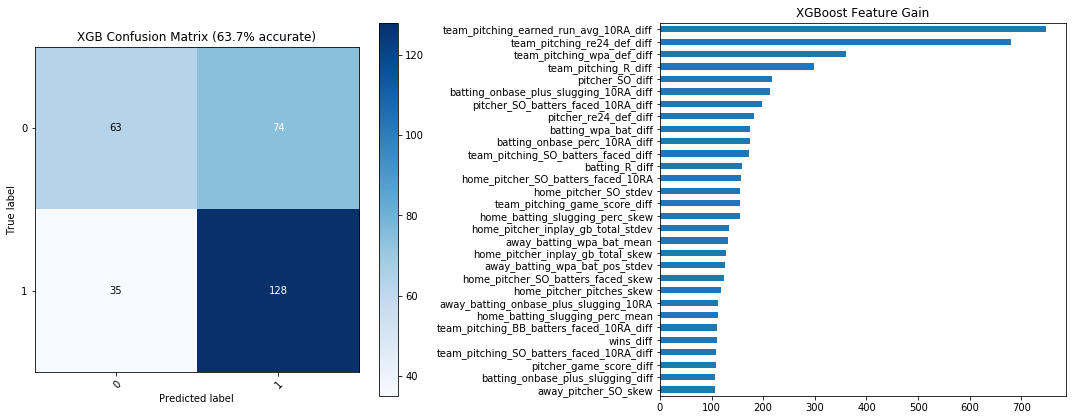

In [11]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], ax=ax[0], 
                           title = f"XGB Confusion Matrix ({accuracy_score(y_valid, xgb_test_preds)*100:.1f}% accurate)")

fig.tight_layout()

In [36]:
import pickle
pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

# Hyperopt

In [12]:
def xgb_objective(params, data):
    params['max_depth']=int(params['max_depth'])
    
    np.random.seed(13)
#     X,y = data
#     xgb_class = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13)
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
#     scores = cross_val_score(xgb_class, X, y, cv=kfold, n_jobs=-1, scoring='roc_auc')
#     return {'loss': -np.mean(scores), 'status':'ok'}
    X_train,y_train,X_valid,y_valid = data
    gbm = xgb.XGBClassifier(**params, num_boost_round=100, random_state=13)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    xgb_test_preds = model.predict(X_valid)
    return(-roc_auc_score(y_valid, xgb_test_preds))
    
def get_xgbparams(X,y):
    # find hyperparaams
    space = {
        'max_depth':  hp.quniform('max_depth', 10, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 2, 20, 1),
        'subsample': hp.quniform('subsample', 0.05, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.05, 1, 0.05),
        'reg_alpha': hp.qloguniform('reg_alpha', -4, 5, 1e-5),
        'learning_rate': hp.qloguniform('learning_rate', -4, -0.5, 1e-2),
    }
    trials = Trials()
    fmin_objective = partial(xgb_objective, data=(X_train,y_train,X_valid,y_valid))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials)
    return params

In [13]:
xgb_params = get_xgbparams(X_train,y_train)
xgb_params['max_depth']=int(xgb_params['max_depth'])
xgb_params

100%|██████████| 50/50 [23:25<00:00, 35.90s/it, best loss: -0.6407407407407407]


{'colsample_bytree': 0.75,
 'learning_rate': 0.06,
 'max_depth': 28,
 'min_child_weight': 14.0,
 'reg_alpha': 0.42431,
 'subsample': 0.2}

# Model

In [16]:
xgb_params['learning_rate']=0.01

In [22]:
xgb_params

{'colsample_bytree': 0.75,
 'learning_rate': 0.01,
 'max_depth': 28,
 'min_child_weight': 14.0,
 'reg_alpha': 0.42431,
 'subsample': 0.2}

In [21]:
# gbm = xgb.XGBClassifier(num_boost_round=100, random_state=13)
# gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=13)
# model = gbm.fit(X_train, y_train,verbose=False)
gbm = xgb.XGBClassifier(**xgb_params, num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=True,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
xgb_test_preds = model.predict(X_valid)
xgb_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, xgb_test_preds), roc_auc_score(y_valid, xgb_test_preds)

[0]	validation_0-error:0.4458	validation_1-error:0.443333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.426528	validation_1-error:0.383333
[2]	validation_0-error:0.411968	validation_1-error:0.403333
[3]	validation_0-error:0.4017	validation_1-error:0.383333
[4]	validation_0-error:0.395093	validation_1-error:0.38
[5]	validation_0-error:0.389286	validation_1-error:0.366667
[6]	validation_0-error:0.384489	validation_1-error:0.363333
[7]	validation_0-error:0.383942	validation_1-error:0.36
[8]	validation_0-error:0.380534	validation_1-error:0.343333
[9]	validation_0-error:0.379103	validation_1-error:0.343333
[10]	validation_0-error:0.376494	validation_1-error:0.35
[11]	validation_0-error:0.376788	validation_1-error:0.366667
[12]	validation_0-error:0.375231	validation_1-error:0.366667
[13]	validation_0-error:0.374558	validation_1-error:0.356667
[14]	valida

(0.6566666666666666, 0.6461279461279461)

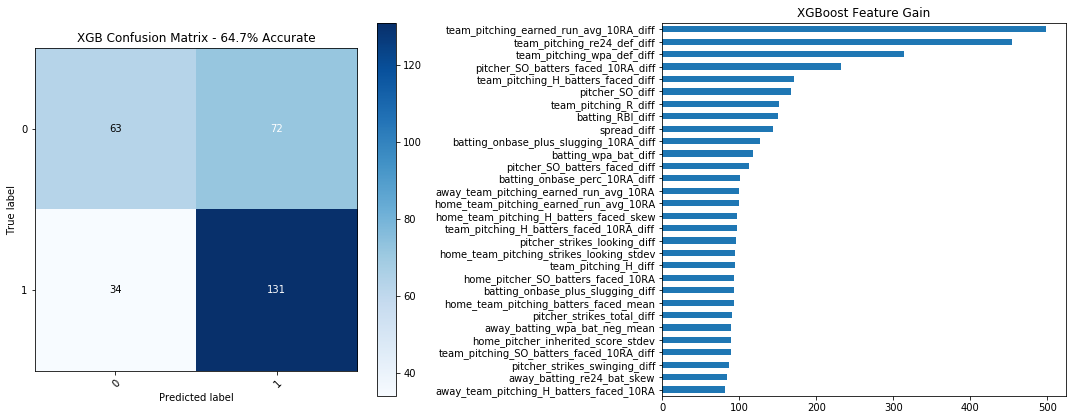

In [18]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-30:].plot(kind='barh',ax=ax[1], title="XGBoost Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"XGB Confusion Matrix - {accuracy_score(y_valid, xgb_test_preds)*100:.1f}% Accurate")

fig.tight_layout()

In [19]:
import pickle
pickle.dump((encoder, model), open('../data/encoder_model.pk','wb'))

# LightGBM

In [12]:
import lightgbm as lgbm

In [14]:
gbm = lgbm.LGBMClassifier(num_boost_round=100, random_state=-1)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

(0.6066666666666667, 0.5892255892255893)

In [17]:
def lgbm_objective(params, data):
    X_train,y_train,X_valid,y_valid = data
    params['num_leaves']=int(params['num_leaves'])
    params['min_child_samples']=int(params['min_child_samples'])
    params['max_bin']=int(params['max_bin'])
    params['bagging_freq']=int(params['bagging_freq'])
    
    np.random.seed(13)
    gbm = lgbm.LGBMClassifier(**params, num_boost_round=100, random_state=-1)
    model = gbm.fit(X_train, y_train,
                    verbose=False,
                    eval_set = [[X_train, y_train],
                              [X_valid, y_valid]],
                    early_stopping_rounds=15)
    lgbm_test_preds = model.predict(X_valid)
    return -roc_auc_score(y_valid,lgbm_test_preds)

def get_lgbmparams(X_train,y_train,X_valid,y_valid):
    # find hyperparaams
    space = {
        'boosting_type': hp.choice('boosting_type', ['gbdt','dart']),
        'subsample': hp.quniform('subsample', 0.5, 1, .05),
        'num_leaves': hp.quniform('num_leaves', 5, 150, 1),
        'learning_rate': hp.qloguniform('learning_rate', -4, -0.5, 1e-2),
        'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
        'reg_alpha': hp.quniform('reg_alpha', 0.0, 1.0,.05),
        'reg_lambda': hp.quniform('reg_lambda', 0.0, 1.0,.05),
        'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0,.05),
        'bagging_freq': hp.quniform ('bagging_freq', 1, 5, 1),
        'max_bin': hp.quniform ('max_bin', 64, 512, 1)
    }
    trials = Trials()
    fmin_objective = partial(lgbm_objective, data=(X_train,y_train,X_valid,y_valid))
    
    params = fmin(fmin_objective,
        space=space,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials)
    return params

In [18]:
lgbm_params = get_lgbmparams(X_train,y_train,X_valid,y_valid)

100%|██████████| 50/50 [06:06<00:00,  5.63s/it, best loss: -0.6292929292929292]


In [21]:
if lgbm_params['boosting_type']==0:lgbm_params['boosting_type']='gbdt'
if lgbm_params['boosting_type']==1:lgbm_params['boosting_type']='dart'
if lgbm_params['boosting_type']==2:lgbm_params['boosting_type']='goss'
lgbm_params['num_leaves']=int(lgbm_params['num_leaves'])
lgbm_params['min_child_samples']=int(lgbm_params['min_child_samples'])
lgbm_params['max_bin']=int(lgbm_params['max_bin'])
lgbm_params['bagging_freq']=int(lgbm_params['bagging_freq'])

lgbm_params

{'bagging_freq': 4,
 'boosting_type': 'dart',
 'colsample_by_tree': 0.9500000000000001,
 'learning_rate': 0.02,
 'max_bin': 100,
 'min_child_samples': 385,
 'num_leaves': 19,
 'reg_alpha': 0.30000000000000004,
 'reg_lambda': 0.45,
 'subsample': 0.65}

In [26]:
gbm = lgbm.LGBMClassifier(**lgbm_params, num_boost_round=100, random_state=13)
model = gbm.fit(X_train, y_train,
                verbose=False,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                early_stopping_rounds=15)
lgbm_test_preds = model.predict(X_valid)
lgbm_test_proba = model.predict_proba(X_valid)[:,1]
accuracy_score(y_valid, lgbm_test_preds), roc_auc_score(y_valid, lgbm_test_preds)

(0.6266666666666667, 0.6114478114478115)

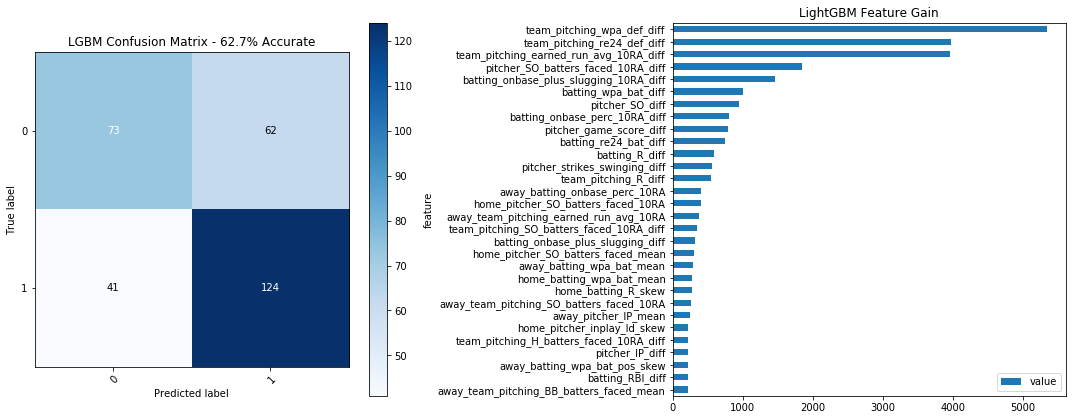

In [27]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

model.importance_type='gain'
l = pd.DataFrame(zip(X_train.columns,model.feature_importances_), 
                 columns=['feature','value']).set_index('feature').sort_values(by='value')
l[-30:].plot(kind='barh',ax=ax[1],title="LightGBM Feature Gain")

util.plot_confusion_matrix(y_valid, xgb_test_preds, [0,1], 
                           ax=ax[0], title = f"LGBM Confusion Matrix - {accuracy_score(y_valid, lgbm_test_preds)*100:.1f}% Accurate")

fig.tight_layout()